In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import os
import os.path

import statistics as stat
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.optimize import curve_fit
from sklearn import linear_model
import scipy.ndimage as sp
import seaborn as sns
from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic

import random


## From here, I'm going to try to simulate Bayesian leaner agents try to do restless bandit, and then fit HMM to examine p(explore)

### code to generate restless walk

In [2]:
'''This function takes in a list of reward probabilities and a number that indicates the number of lags 
(usually set at lags = 50 but ot's flexible), and returns a list of correlation efficients at each lag. 
The length of this returned list should be the same number of lags'''
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in range (lags)]
    return np.array(corr)

In [3]:
'''This functions takes in a list of three lists of reward probabilities and returns a number that indicate the average half 
life of the walk.'''
def halflife(walk):

    armA = walk[0]
    armB = walk[1]
    armC = walk[2]
    corr = []
    halflife = 0

    autoc1 = autocorr1(armA,50).tolist()
    autoc2 = autocorr1(armB,50).tolist()
    autoc3 = autocorr1(armC,50).tolist()

    for m in range (len(autoc1)):
        corr.append((autoc1[m]+autoc2[m]+autoc3[m])/3)

    for p in range (len(corr)):
        if corr[p]>= 0.5: 
            halflife += 1

    return (halflife)

In [4]:
def walk():
    while True:
        ######################## SET PARAMETERS ########################
        armNum = 3  ##3-armed bandit
        walkList =[] ### contains three lists of rewawrd prob, one for each arm
        initialProbList = [0.9,0.7,0.3]  ## set initial values 
        random.shuffle(initialProbList)  ## randomize inital values for each arm
        hazard = 0.2  ## harzard rate
        step = 0.2  ## step size
        trialNum = 300  ## number of trials
        bounds = [0.1,0.8] ## upper and lower bounds of reward probs
        
        for i in range (armNum):
            ### first while loop aims to find an individual arm that walks up and down over 300 trials
            #print ('individual')

            #### step = 0.2, and hazard rate. = 0.33. Mean = 9.8 and sd < 2
            while True:
                armList = []
                prob = initialProbList[i] ## add the first vaue in
                armList.append(prob)

                for j in range (trialNum-1):
                    rand = np.random.random()
                    if rand <= hazard: ### change occurs this trial, append the new prob
                        if prob >= round (bounds[1],1):
                            prob = prob - step
                            armList.append(prob)

                        elif prob <= round (bounds[0] , 1):
                            prob = prob + step
                            armList.append(prob)

                        else:
                            action = np.random.choice (['up', 'down'], 1)
                            if action == 'up':
                                prob = prob + step
                                armList.append(prob)
                            else:
                                prob = prob - step
                                armList.append(prob)
                    else:  ## no change occurs on this trial, append the same prob
                        armList.append(prob)


                ### defining some criteria for individual walks

                ### for each walk, the range (maximum-minimum) should be over 0.6
                maxDiff = max(armList)-min(armList)

                ### the average of each walk should be around 50% (48%-52%)
                average = np.average(armList)
                
    

                #myList = list(np.around(np.array(armList),2))*100

                if maxDiff >= 0.6 and 0.48 <= average <=0.52 :
                    break
            
            myList = list(np.around(np.array(armList),2))
            walkList.append(myList) 
            
        halfLife = halflife (walkList)
        
        ### the half life of autocorrelation of the alk should have mean = 10, sd = 2
        if 8 <= halfLife <= 15:
            break

    richness = np.sum(walkList)/trialNum
            
    return (walkList, halfLife, richness)  

### first HMM codes

In [5]:
def forward (V, a, b, initial_distribution):
    ## probability of being in state j at trial t, output is T*M matrix, T is number of trials, M is number of states
    alpha = np.zeros((V.shape[0],a.shape[0]))
    alpha[0, :] = initial_distribution * b[:, V[0]]
    for t in range(1, V.shape[0]):
        for j in range(a.shape[0]):
            alpha[t, j] = alpha[t - 1].dot(a[:, j]) * b[j, V[t]]
    return alpha

In [6]:
def backward (V, a, b):
    ## time-reversed version of forward algoritms
    ## output is T*M matrix, T is number of trials, M is number of states
    beta = np.zeros((V.shape[0], a.shape[0]))
 
    # setting beta(T) = 1
    beta[V.shape[0] - 1] = np.ones((a.shape[0]))
 
    # Loop in backward way from T-1 to
    # Due to python indexing the actual loop will be T-2 to 0
    for t in range(V.shape[0] - 2, -1, -1):
        for j in range(a.shape[0]):
            beta[t, j] = (beta[t + 1] * b[:, V[t + 1]]).dot(a[j, :])
 
    return beta

In [7]:
def baum_welch(V, a, b, initial_distribution, n_iter=100, parameterTying = True):
    M = a.shape[0]  ## number of states
    T = len(V) ##  number of trials
    
    for n in range(n_iter):
        
        alpha = forward(V, a, b, initial_distribution)
        beta = backward(V, a, b)

        ## xi = p (s(t) = i, s(t+1) = j | observation, model)
        xi = np.zeros((M, M, T - 1))
        for t in range(T - 1):
            denominator = np.dot(np.dot(alpha[t, :].T, a) * b[:, V[t + 1]].T, beta[t + 1, :])
            for i in range(M):
                numerator = alpha[t, i] * a[i, :] * b[:, V[t + 1]].T * beta[t + 1, :].T
                xi[i, :, t] = numerator / denominator

        ## gamma = p (s(t)=i |observation, model) = sum_j^M {xi}
        gamma = np.sum(xi, axis=1)

        transMatrixNum = np.sum(xi, 2)
        transMatrixDem = np.sum(gamma, axis=1).reshape((-1, 1))
        
        ## a is the transition matrix being iteratively optmized and will eventually converge
        a = transMatrixNum/transMatrixDem

        # Add additional T'th element in gamma
        #gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))
        
    ## tie parameter here
    if parameterTying:
        a[0,1] = (a[0,1] + a[0,2] + a[0,3])/3
        a[0,2] = a[0,1]
        a[0,3] = a[0,1]

        a[1,1] = (a[1,1] + a[2,2] + a[3,3])/3
        a[2,2] = a[1,1]
        a[3,3] = a[1,1]

        a[1,0] = (a[1,0]+a[2,0] + a[3,0])/3
        a[2,0] = a[1,0]
        a[3,0] = a[1,0]

    return a

In [8]:
def viterbi(V, a, b, initial_distribution):
    T = V.shape[0] ## 300 - time.trial
    M = a.shape[0] ## number of states - 3

    omega = np.zeros((T, M))
    #omega[0, :] = np.log(initial_distribution * b[:, V[0]]) # prior
    omega[0, :] = (initial_distribution * b[:, V[0]]) # prior

    prev = np.zeros((T - 1, M)) 
 
    for t in range(1, T):
        for j in range(M):
            # Same as Forward Probability
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])
            
    
 
            # This is our most probable state given previous state at time t (1)
            prev[t - 1, j] = np.argmax(probability)
 
            # This is the probability of the most probable state (2)
            omega[t, j] = np.max(probability)
 
    # Path Array
    S = np.zeros(T)
 
    # Find the most probable last hidden state
    last_state = np.argmax(omega[T - 1, :])
 
    S[0] = last_state
 
    backtrack_index = 1
    for i in range(T - 2, -1, -1):
        S[backtrack_index] = prev[i, int(last_state)]
        last_state = prev[i, int(last_state)]
        backtrack_index += 1
 
    # Flip the path array since we were backtracking
    result = np.flip(S, axis=0)
 
    return result

In [9]:
### rewrite this to run HMM and return p(explore)
def HMM_main(choice):

    ## emission probs (p(choice|state))
    b = np.array([[1/3,1/3,1/3],[1,0,0],[0,1,0],[0,0,1]])

    # initial prob distribution
    initial_distribution = np.array((1,0,0,0))

    ## initial transition matrix
    a = np.array([[1/4,1/4,1/4,1/4],[1/2,1/2,0,0],[1/2,0,1/2,0],[1/2,0,0,1/2]])

    # for simulation, I will skip the reseed part
    transMatrix =baum_welch(choice,a,b,initial_distribution, n_iter =100)

    ## fit back to each session using viterbi algorithms
    stateLabel = viterbi(choice,transMatrix,b,initial_distribution).tolist()

    pExplore = stateLabel.count(0)/len(stateLabel)
  
    return pExplore

### next, Bayesian learner simulation

In [10]:
def KF_agent (beta, phi, persev, walkList, n_trials):

    n_options = 3

    # Initialize beliefs about mean rewards and uncertainties for each option
    v = np.full(n_options, 0.5)  # Assuming binary rewards, 0.5 is a neutral initial belief
    sig = np.full(n_options, np.sqrt(0.5 * (1 - 0.5)))  # Initial uncertainty based on Bernoulli variance
    sigO = 0.25 # observation noise

    decay = 0.99  # Decay parameter
    decay_center = 0.5  # Decay center
    sigD = 0.1  # Diffusion variance

    # first choice is random (choice is 0 or 1 or 2)
    firstChoice = np.random.choice(3,1)[0]
    currentChoice = firstChoice

    # trial-by-trial variables are stored in the list
    choiceList = [firstChoice]
    rewardList = []

    # start the loop here:
    for i in range (n_trials-1):

        ## whether the chosen choice is rewarded or not
        rand = np.random.random()
        if rand < walkList[currentChoice][i]:
            reward = 1
            rewardList.append(reward)
        else:
            reward = 0
            rewardList.append(reward)

        ## Update beliefs for chosen option using a simplified model
        pe = reward - v[currentChoice]  ## prediction error

        Kgain = sig[currentChoice]**2 / (sig[currentChoice]**2 + sigO**2)  # kalman gain (learning rate)
        
        v[currentChoice] += Kgain * pe  # Update the mean belief of the current choice, using kalman gain and prediction error

        sig[currentChoice] = np.sqrt((1 - Kgain) * sig[currentChoice]**2)  # Update the uncertainty (variance) of the current choice, using Kalman gain

        eb = phi * sig  # Exploration bonus is a exploration weight phi * variance

        ## if chosen choice was a stay/repeat of previous choice, add a perservation bonus
        pb = np.zeros(3)
        if i > 0:
            if currentChoice == choiceList[-2]:
                pb[currentChoice] = persev

        ## the utility contains three parts: value, weighted uncertainty, and perseveration bonus
        utilities = v + eb + pb

        ## utilities go through Softmax for action selection for next trial
        prob0 = (np.exp((utilities[0])*beta))/(np.exp((utilities[0])*beta)+np.exp((utilities[1])*beta)+np.exp((utilities[2])*beta))
        prob1 = (np.exp((utilities[1])*beta))/(np.exp((utilities[0])*beta)+np.exp((utilities[1])*beta)+np.exp((utilities[2])*beta))

        rand1 = np.random.random()
        if rand1 <= prob0:
            currentChoice = 0
        elif prob0 < rand1 <= (prob0+prob1):
            currentChoice = 1
        else:
            currentChoice = 2
        choiceList.append (currentChoice)

        # Apply decay to beliefs and uncertainties for all three choices, to ensure learning of a changin/diffusing system
        v = decay * v + (1 - decay) * decay_center
        sig = np.sqrt(decay**2 * sig**2 + sigD**2)


    return choiceList, rewardList

### here define a main function to run the Bayesian simulation and fit HMM to each run.

In [11]:
def Bayesian_sim(replication):

    phiList = []
    betaList = []
    persevList = []
    exploreList = []

    ## generate a walk here:
    walkList, halfLife, richness = walk()
    
    for i in range (replication):
        # walkList, halfLife, richness = walk()
        ## randomize parameters here           
        beta = np.random.uniform(0,4)  ## starting from moderate weight
        phi = np.random.uniform(0,4)
        # persev = np.random.uniform(0,0.2) ## starting from low perseveration
        persev = 0.4

        phiList.append(phi)
        betaList.append(beta)
        persevList.append(persev)
        
        ## generate sim data
        choice, outcome = KF_agent (beta, phi, persev, walkList, n_trials=300)
        
        ## label state and extract pExplore
        pExplore = HMM_main(np.asarray(choice))
        exploreList.append(pExplore)
        
        
    ###final output here
    Dict = { 'phi': phiList, 'beta' : betaList, 'persev': persevList,'pExplore': exploreList}
    df = pd.DataFrame(Dict)
    df.to_csv('HMMsimBayesian.csv')

    return phiList, betaList, persevList, exploreList

In [12]:
def heatmap(inputList):

    x = inputList[0]
    y = inputList[1]
    z = inputList[2]
    
    x_bins = np.linspace(0, 4, 10)
    y_bins = np.linspace(0, 4, 10)
    ret = binned_statistic_2d(x, y, z, statistic=np.mean, bins=[x_bins, y_bins])
    
    n_bins = 8
    
    

    bin_centers, _, _ = binned_statistic(x, x, statistic='mean', bins=n_bins)
    bin_averages, _, _ = binned_statistic(x, z,statistic='mean', bins=n_bins)
    bin_stdevs, _, _ = binned_statistic(x, z,statistic='std', bins=n_bins)
    
    bin_centers1, _, _ = binned_statistic(y, y, statistic='mean', bins=n_bins)
    bin_averages1, _, _ = binned_statistic(y, z,statistic='mean', bins=n_bins)
    bin_stdevs1, _, _ = binned_statistic(y, z,statistic='std', bins=n_bins)


    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(20, 4))
    
    im = ax1.imshow(ret.statistic.T, origin = 'lower', extent=(0, 4, 0, 4))
    plt.colorbar(im)
    ax1.set_xlabel('phi')
    ax1.set_ylabel('beta')
    
    ax2.errorbar(bin_centers, bin_averages, bin_stdevs/100, color="black", label="avg with stdev")
    ax2.set_xlabel('phi')
    ax2.set_ylabel('p(explore)')
    
    
    
    ax3.errorbar(bin_centers1, bin_averages1, bin_stdevs1/100, fmt="-", color="black", label="avg with stdev")
    ax3.set_xlabel('beta')
    ax3.set_ylabel('p(explore)')
    
    
    #ax2.scatter(x, z)

    # plt.show()
    
    plt.savefig('heatmap and regression Bayesian learner HMM.eps', format = 'eps',dpi = 1000)

c:\Users\Cathy\miniconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


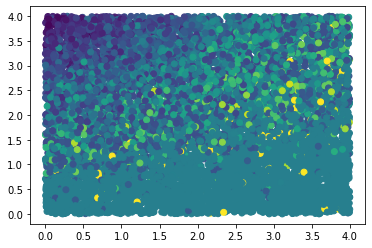

In [13]:
## run the simulation here
phiList, betaList, persevList, exploreList = Bayesian_sim(replication=10000)

## plot scatter plot here, side by side
fig = plt.figure()
#ax = fig.add_subplot (111, projection = '3d')
plt.scatter(phiList, betaList, c=exploreList)

#ax.set_xlabel ('alpha')
#ax.set_ylabel ('beta')
plt.show()
    
## plot heatmap here
# heatmap([phiList,betaList,exploreList])

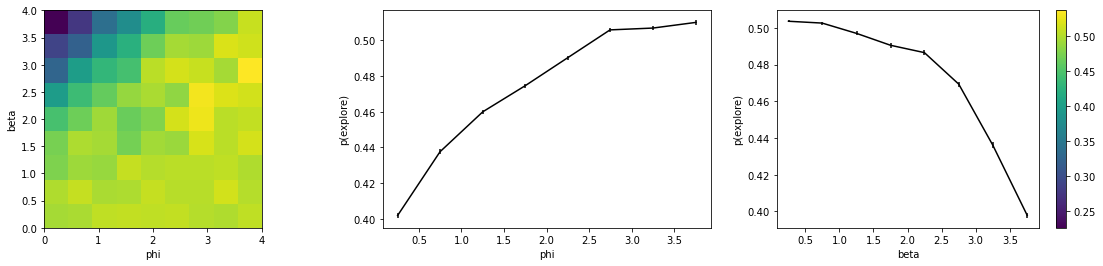

In [14]:
df1 = pd.read_csv('C:/Users/Cathy/Desktop/HMMsimBayesian.csv')
phiList = df1['phi'].tolist()
betaList = df1['beta'].tolist()
exploreList = df1['pExplore'].tolist()
heatmap([phiList,betaList,exploreList])